# Step 0: Import Libraries

In [24]:
#Importing libraries
import os
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno


# Step 1: Import Data

In [2]:
#Setting directory

os.chdir(r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Projects\Auto Recalls\Auto-Recalls')

In [3]:
#Recalls Data
#csv_url = "https://datahub.transportation.gov/resource/6axg-epim.csv"

recalls_raw = pd.read_csv("Recalls_data.csv")

recalls_raw.head()

,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,Consequence Summary,Corrective Action
0,01/25/2023,23V027000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Kia America, Inc.",Improperly Molded Fuel Tank May Leak,"FUEL SYSTEM, GASOLINE",SC261,Vehicle,34.0,"Kia America, Inc. (Kia) is recalling certain 2...",A fuel leak in the presence of an ignition sou...,"Deales will inspect and replace the fuel tank,..."
1,01/25/2023,23V028000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Hyundai Motor America,Improperly Molded Fuel Tank May Leak,"FUEL SYSTEM, GASOLINE",240,Vehicle,326.0,Hyundai Motor America (Hyundai) is recalling c...,A fuel leak in the presence of an ignition sou...,Dealers will inspect and replace the fuel tank...
2,01/25/2023,23V026000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"BMW of North America, LLC",Pedestrian Warning Sound Malfunction/FMVSS 141,BACK OVER PREVENTION,NR (Not Reported),Vehicle,3431.0,"BMW of North America, LLC (BMW) is recalling c...","Without external warning sounds, pedestrians m...",Dealers will update the external artificial so...
3,01/23/2023,23V017000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Isuzu Motors Limited,Emergency Braking and Steering Control Malfunc...,ELECTRICAL SYSTEM,V2301,Vehicle,242.0,Isuzu Motors Limited (Isuzu) is recalling cert...,An improperly calibrated ADAS camera and ABS m...,Dealers will recalibrate the ADAS camera and A...
4,01/23/2023,23V020000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Alamo Group Inc.,Exhaust Silencer May Detach,EQUIPMENT,NR (Not Reported),Vehicle,56.0,Alamo Group Inc. (Alamo Group) is recalling ce...,A detached exhaust silencer can become a road ...,Gradall Dealers will inspect the exhaust silen...


# Step 2: Describe Data

In [4]:
#Describe recalls dataset
print(recalls_raw.columns)
print(recalls_raw.info())
print(recalls_raw.describe())
print(recalls_raw.shape)

print(recalls_raw.head())

Index(['Report Received Date', 'NHTSA ID', 'Recall Link', 'Manufacturer',
       'Subject', 'Component', 'Mfr Campaign Number', 'Recall Type',
       'Potentially Affected', 'Recall Description', 'Consequence Summary',
       'Corrective Action'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26616 entries, 0 to 26615
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Report Received Date  26616 non-null  object 
 1   NHTSA ID              26616 non-null  object 
 2   Recall Link           26616 non-null  object 
 3   Manufacturer          26616 non-null  object 
 4   Subject               26616 non-null  object 
 5   Component             26616 non-null  object 
 6   Mfr Campaign Number   26587 non-null  object 
 7   Recall Type           26616 non-null  object 
 8   Potentially Affected  26574 non-null  float64
 9   Recall Description    24215 non-null  object 
 10  Cons

In [5]:
#unique values

print('\nNY Recalls Data - Unique Values:')
for x in recalls_raw.columns:
    print(x+':')
    print(recalls_raw[x].unique())
    print(str(recalls_raw[x].nunique()) + str(' unique values'))


NY Recalls Data - Unique Values:
Report Received Date:
['01/25/2023' '01/23/2023' '01/20/2023' ... '09/29/1966' '09/19/1966'
 '01/19/1966']
9548 unique values
NHTSA ID:
['23V027000' '23V028000' '23V026000' ... '66V032001' '66V032003'
 '66V032004']
26616 unique values
Recall Link:
['Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V027000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V028000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V026000)' ...
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032001)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032003)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032004)']
26616 unique values
Manufacturer:
['Kia America, Inc.' 'Hyundai Motor America' 'BMW of North America, LLC'
 ... 'SS AUTOS, INC.' 'ALGAR ENTERPRISES, INC.' 'ULTRA, INC.']
2935 unique values
Subject:
['Improperly Molded Fuel Tank May Leak'
 'Pedestrian Warning Sound Malfunction/FMVSS 141'
 'Emergency Braking and Steer

# Step 3: Clean & Manipulate Data

## Timestamp Work

In [6]:
#converting to datetime object
recalls_raw['Report Received Date']=pd.to_datetime(recalls_raw['Report Received Date'])

#Adding year info
recalls_raw['Year']=pd.DatetimeIndex(recalls_raw['Report Received Date']).year

#Adding decade info
# define a function to convert a year to a decade
def get_decade(year):
    return str(year // 10 * 10) + 's'

# applying get_decade function to the 'year' column
recalls_raw['Decade'] = recalls_raw['Year'].apply(get_decade)
            
#sanity check
recalls_raw.head()

,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,Consequence Summary,Corrective Action,Year,Decade
0,2023-01-25,23V027000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Kia America, Inc.",Improperly Molded Fuel Tank May Leak,"FUEL SYSTEM, GASOLINE",SC261,Vehicle,34.0,"Kia America, Inc. (Kia) is recalling certain 2...",A fuel leak in the presence of an ignition sou...,"Deales will inspect and replace the fuel tank,...",2023,2020s
1,2023-01-25,23V028000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Hyundai Motor America,Improperly Molded Fuel Tank May Leak,"FUEL SYSTEM, GASOLINE",240,Vehicle,326.0,Hyundai Motor America (Hyundai) is recalling c...,A fuel leak in the presence of an ignition sou...,Dealers will inspect and replace the fuel tank...,2023,2020s
2,2023-01-25,23V026000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"BMW of North America, LLC",Pedestrian Warning Sound Malfunction/FMVSS 141,BACK OVER PREVENTION,NR (Not Reported),Vehicle,3431.0,"BMW of North America, LLC (BMW) is recalling c...","Without external warning sounds, pedestrians m...",Dealers will update the external artificial so...,2023,2020s
3,2023-01-23,23V017000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Isuzu Motors Limited,Emergency Braking and Steering Control Malfunc...,ELECTRICAL SYSTEM,V2301,Vehicle,242.0,Isuzu Motors Limited (Isuzu) is recalling cert...,An improperly calibrated ADAS camera and ABS m...,Dealers will recalibrate the ADAS camera and A...,2023,2020s
4,2023-01-23,23V020000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Alamo Group Inc.,Exhaust Silencer May Detach,EQUIPMENT,NR (Not Reported),Vehicle,56.0,Alamo Group Inc. (Alamo Group) is recalling ce...,A detached exhaust silencer can become a road ...,Gradall Dealers will inspect the exhaust silen...,2023,2020s


In [7]:
#trimming dataframe 
recalls = recalls_raw[['Report Received Date','Manufacturer','Subject',
                                'Component','Recall Type','Potentially Affected',
                                'Year','Decade']]
print(recalls.head())

print(recalls.info())

  Report Received Date               Manufacturer  \
0           2023-01-25          Kia America, Inc.   
1           2023-01-25      Hyundai Motor America   
2           2023-01-25  BMW of North America, LLC   
3           2023-01-23       Isuzu Motors Limited   
4           2023-01-23           Alamo Group Inc.   

                                             Subject              Component  \
0               Improperly Molded Fuel Tank May Leak  FUEL SYSTEM, GASOLINE   
1               Improperly Molded Fuel Tank May Leak  FUEL SYSTEM, GASOLINE   
2     Pedestrian Warning Sound Malfunction/FMVSS 141   BACK OVER PREVENTION   
3  Emergency Braking and Steering Control Malfunc...      ELECTRICAL SYSTEM   
4                        Exhaust Silencer May Detach              EQUIPMENT   

  Recall Type  Potentially Affected  Year Decade  
0     Vehicle                  34.0  2023  2020s  
1     Vehicle                 326.0  2023  2020s  
2     Vehicle                3431.0  2023  2020s  
3 

In [8]:
#Separating recalls by potentially affected missing/complete
affected_missing = recalls[recalls['Potentially Affected'].isna()]
affected_complete = recalls[~recalls['Potentially Affected'].isna()]

print(affected_missing.describe())
print(affected_complete.describe())

       Potentially Affected         Year
count                   0.0    42.000000
mean                    NaN  2004.023810
std                     NaN     4.999942
min                     NaN  1998.000000
25%                     NaN  2001.000000
50%                     NaN  2002.000000
75%                     NaN  2007.750000
max                     NaN  2022.000000
       Potentially Affected          Year
count          2.657400e+04  26574.000000
mean           4.633660e+04   2003.135998
std            3.832928e+05     15.308455
min            0.000000e+00   1966.000000
25%            1.012500e+02   1994.000000
50%            7.015000e+02   2007.000000
75%            6.431750e+03   2016.000000
max            3.200000e+07   2023.000000


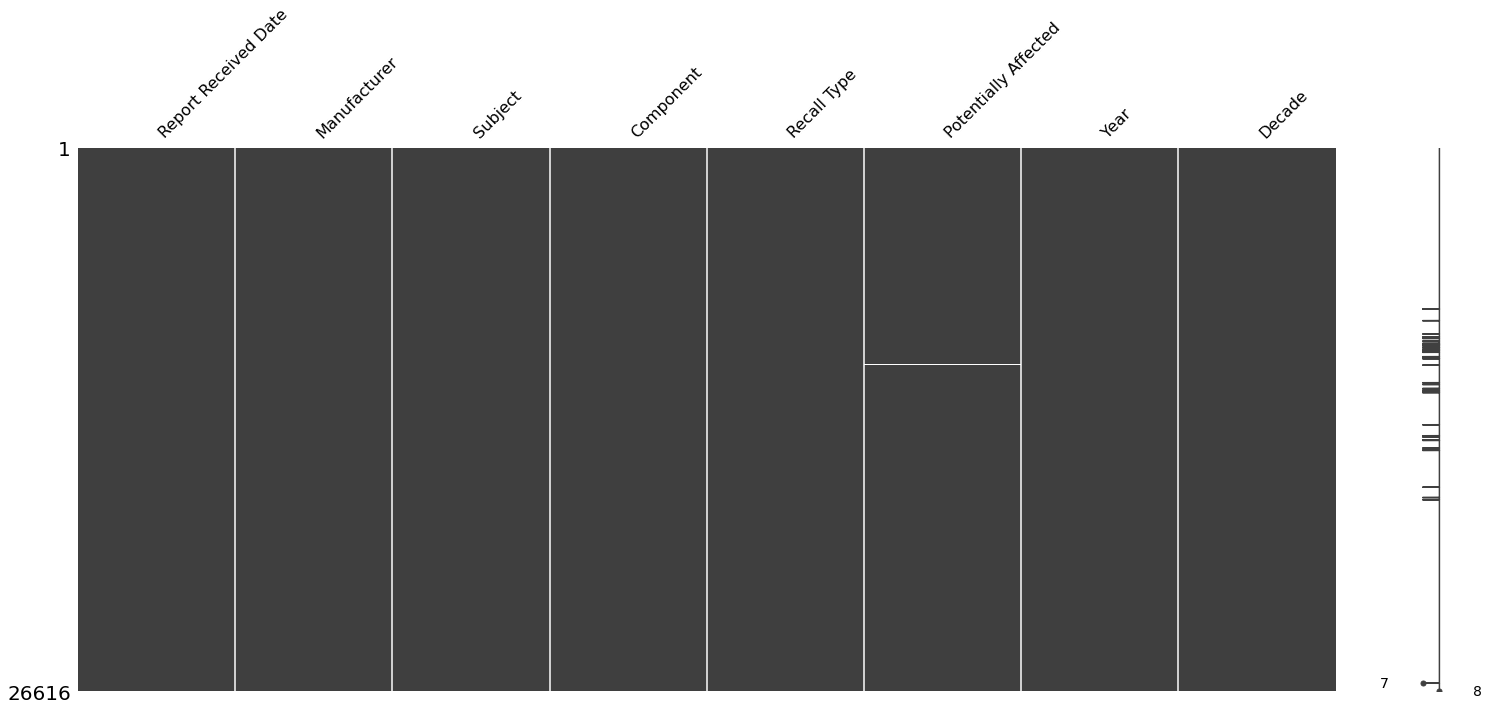

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26616 entries, 26615 to 0
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Report Received Date  26616 non-null  datetime64[ns]
 1   Manufacturer          26616 non-null  object        
 2   Subject               26616 non-null  object        
 3   Component             26616 non-null  object        
 4   Recall Type           26616 non-null  object        
 5   Potentially Affected  26574 non-null  float64       
 6   Year                  26616 non-null  int64         
 7   Decade                26616 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.8+ MB
None


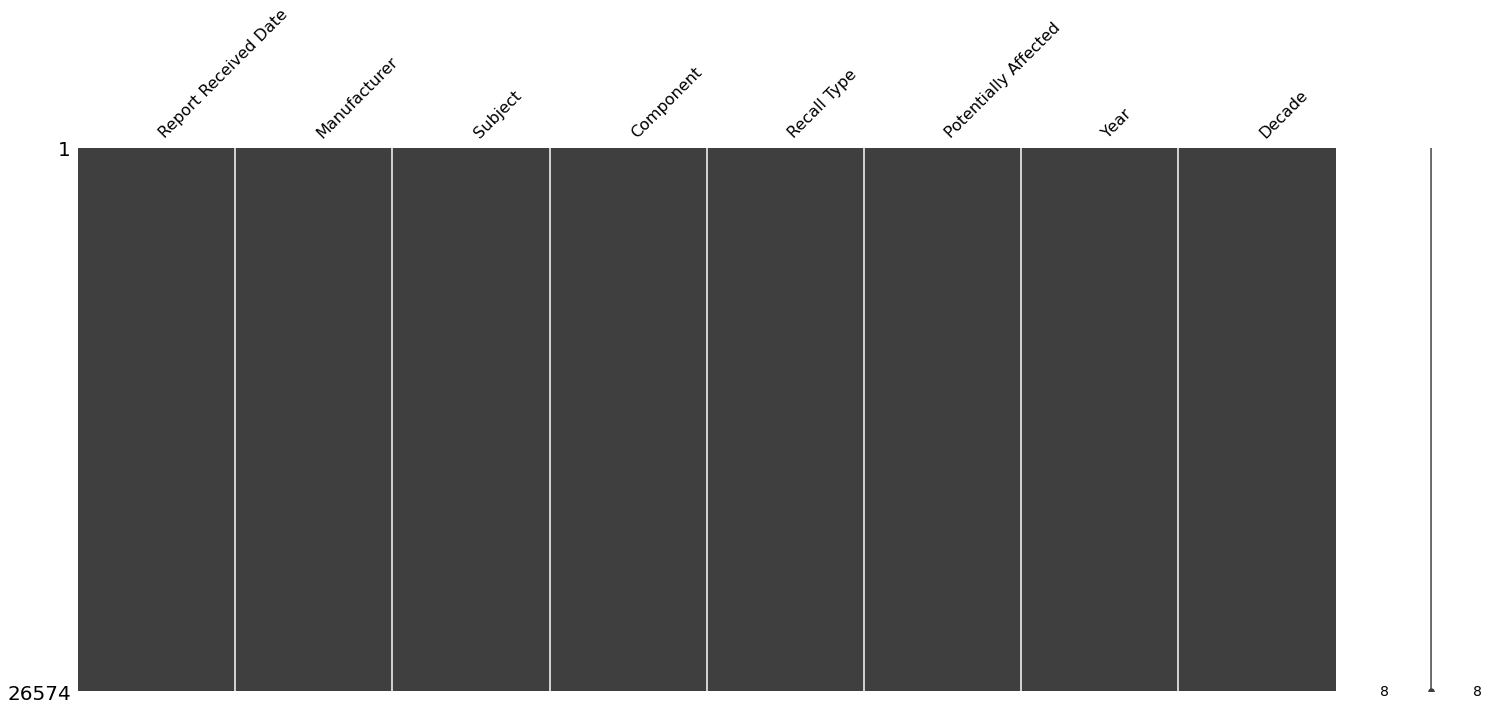

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26574 entries, 0 to 26615
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Report Received Date  26574 non-null  datetime64[ns]
 1   Manufacturer          26574 non-null  object        
 2   Subject               26574 non-null  object        
 3   Component             26574 non-null  object        
 4   Recall Type           26574 non-null  object        
 5   Potentially Affected  26574 non-null  float64       
 6   Year                  26574 non-null  int64         
 7   Decade                26574 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.8+ MB
None


In [9]:
#Visualising missing data

#Sorting values by report received date
sorted_recalls = recalls.sort_values(by='Report Received Date',ascending=True)

#plotting matrix of missing data
msno.matrix(sorted_recalls)
plt.show()

#info of sorted data
print(sorted_recalls.info())

#removing rows with none potentially affected from dataset
recalls = affected_complete

#replotting matrix
msno.matrix(recalls)
plt.show()

#info of remaining dataset
print(recalls.info())

# Step 4: Plot Data

In [32]:
#setting figsize
plt.rcParams["figure.figsize"] = (15, 10)

In [43]:
component_grouped = pd.pivot_table(data=recalls,values = 'Potentially Affected',index = ['Decade','Component'],
                                   aggfunc=['sum','mean'],sort=[False,False]).round(0)

component_grouped = component_grouped.sort_values(by=('Potentially Affected','sum'),ascending=False)
component_grouped

KeyError: ('Decade', 'Potentially Affected', 'sum')

                        Potentially Affected
Component                                   
CHILD SEAT                          242913.0
AIR BAGS                            242425.0
COMMUNICATION                       174782.0
LATCHES/LOCKS/LINKAGES              104223.0
TIRES                                94505.0
VEHICLE SPEED CONTROL                80185.0
BACK OVER PREVENTION                 76519.0
SEAT BELTS                           66895.0
VISIBILITY/WIPER                     61615.0
POWER TRAIN                          59400.0


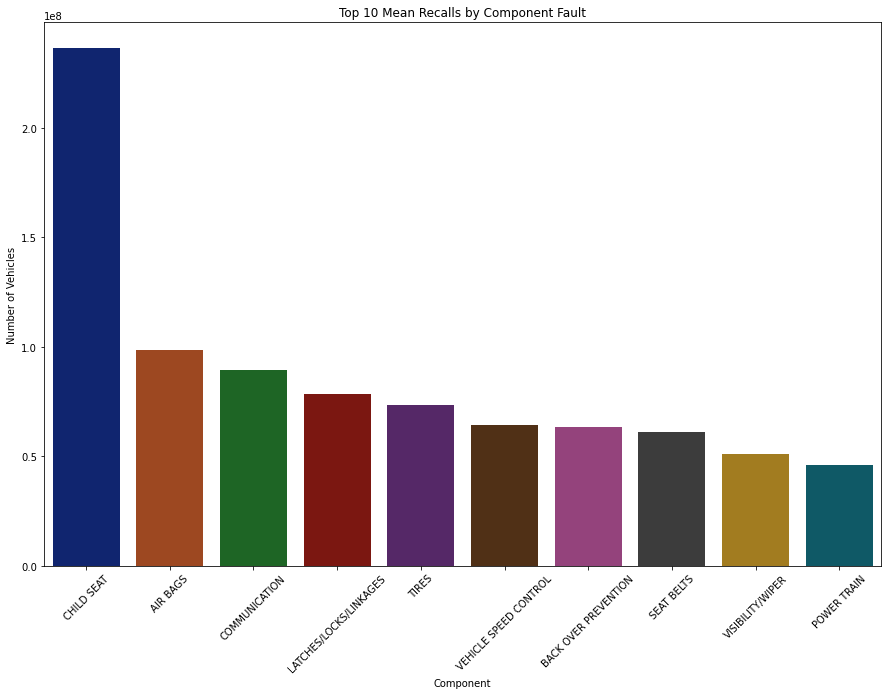

                           Potentially Affected
Component                                      
AIR BAGS                            236364481.0
TIRES                                98568586.0
ELECTRICAL SYSTEM                    89325208.0
FUEL SYSTEM, GASOLINE                78349512.0
POWER TRAIN                          73656468.0
CHILD SEAT                           64129152.0
SEAT BELTS                           63282589.0
SERVICE BRAKES, HYDRAULIC            60988273.0
EXTERIOR LIGHTING                    50913551.0
EQUIPMENT                            46192208.0


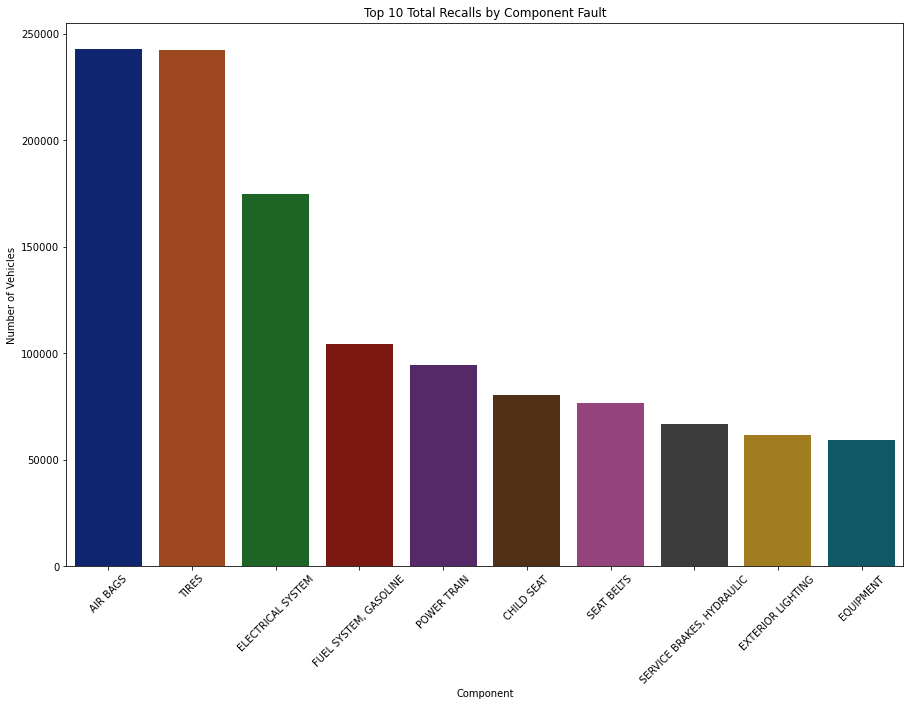

In [27]:
# Group the data by component and calculate the total and mean number of potentially affected vehicles for each component.
component_grouped = recalls[['Component','Potentially Affected']].groupby('Component')
top10_sum_component_affected = component_grouped.sum().sort_values(by='Potentially Affected', ascending=False).head(10)
top10_mean_component_affected = component_grouped.mean().round(0).sort_values(by='Potentially Affected', ascending=False).head(10)

#print top 10 mean recalls by component affected
print(top10_mean_component_affected)

# Create a bar chart for each of the top 10 components based on the total and mean number of potentially affected vehicles.
sns.set_palette('dark')
sns.barplot(x=top10_mean_component_affected.index,y=top10_sum_component_affected['Potentially Affected'])
plt.title('Top 10 Mean Recalls by Component Fault')
plt.xlabel('Component')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.show()

#print top 10 mean recalls by component affected
print(top10_sum_component_affected)

sns.barplot(x=top10_sum_component_affected.index,y=top10_mean_component_affected['Potentially Affected'])
plt.title('Top 10 Total Recalls by Component Fault')
plt.xlabel('Component')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.show()